#### Разбиваем данные на train/test перед обучением модели

In [29]:
import pandas as pd
import xgboost
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score, precision_score,recall_score,accuracy_score, roc_curve
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

target = 'earthquake'

In [17]:
data = pd.read_csv('12_files_marked.csv')
data.sample(5)

,time,620.E,621.E,622.E,623.E,624.E,625.E,626.E,627.E,628.E,629.E,630.E,631.E,632.E,earthquake
229622,2016-12-25 14:10:32.470000,7,4,-2,3,0,-15,0,-3,3,1,0,9,3,0.0
224206,2016-12-27 03:32:39.629900,54,6,-11,7,-8,1,-5,-1,0,-5,-6,5,-8,0.0
207431,2016-12-27 03:29:51.879900,4,4,-6,4,10,0,9,6,-4,1,1,2,0,0.0
33856,2016-12-01 21:54:38.629900,0,-4,-13,1,3,-4,-14,-4,2,5,0,5,94,1.0
194265,2016-12-28 03:59:03.830000,5,1,-5,8,8,3,-5,0,-1,-1,14,5,-27,0.0


In [18]:
X = data.drop([target,'time'],axis = 1)
y = data[target]

print(X.shape)
print(y.shape)

(307883, 13)
(307883,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8, random_state=42)

In [20]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(246306, 13) (61577, 13)
(246306,) (61577,)


### Обучаем модель RandomForestClassifier

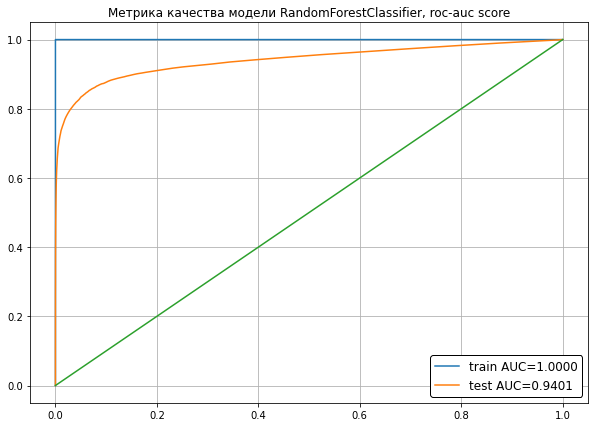

CPU times: user 2min 12s, sys: 87.8 ms, total: 2min 12s
Wall time: 2min 12s


In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict_proba(X_test)

y_train_predicted = clf.predict_proba(X_train)[:, 1]
y_test_predicted = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели RandomForestClassifier, roc-auc score')
plt.show()

In [22]:
print('ROC-AUC score: ',round(roc_auc_score(y_test, y_test_predicted),4))
print('Accuracy score: ',round(accuracy_score(y_test, clf.predict(X_test)),4))
print('Precision score: ',round(precision_score(y_test, clf.predict(X_test),4)))
print('Recall score: ',round(recall_score(y_test, clf.predict(X_test),4)))

ROC-AUC score:  0.9401
Accuracy score:  0.9086
Precision score:  1
Recall score:  1


При запуске с параметрами по умолчанию модель достигает точности почти 1.00 на тренировочных данных, но не может выдать такой же результат на тестовых данных. Это говорит о переобучении модели под тренировочные данные. Решение $-$ уменьшение глубины деревьев и увеличение минимального числа элементов в листе дерева с 1 до 5.

In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100,max_depth = 25, n_jobs = -1,min_samples_split=5,max_features='log2')
clf.fit(X_train, y_train)
prediction = clf.predict_proba(X_test)

CPU times: user 3min 54s, sys: 240 ms, total: 3min 54s
Wall time: 30.5 s


In [24]:
print(round(roc_auc_score(y_test, prediction[:,1]),4))

0.9392


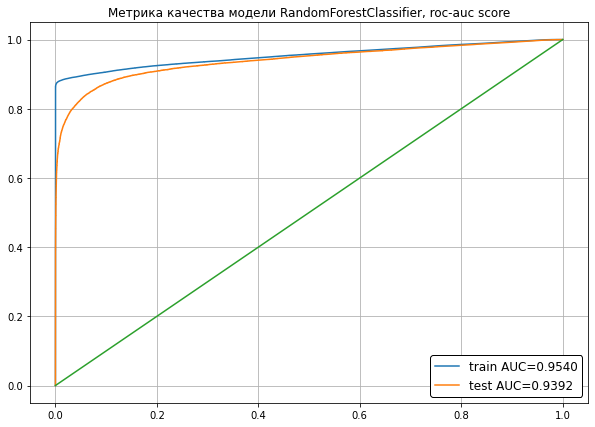

In [25]:
y_train_predicted = clf.predict_proba(X_train)[:, 1]
y_test_predicted = clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели RandomForestClassifier, roc-auc score')
plt.show()

In [26]:
print('ROC-AUC score: ',round(roc_auc_score(y_test, y_test_predicted),4))
print('Accuracy score: ',round(accuracy_score(y_test, clf.predict(X_test)),4))
print('Precision score: ',round(precision_score(y_test, clf.predict(X_test),4)))
print('Recall score: ',round(recall_score(y_test, clf.predict(X_test),4)))

ROC-AUC score:  0.9392
Accuracy score:  0.907
Precision score:  1
Recall score:  1


In [27]:
#Поискать, как можно еще сделать этот график более красивым (график roc auc fine)

Из графика видно, что качество на тренировочной и тестовой выборках почти совпадает, $-$ это значит, что модель не переобучается и хорошо находит зависимости.

### Обучаем модель XGBoost с параметрами по умолчанию

In [33]:
%%time
boosting_model = xgboost.XGBClassifier()

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]
y_test_predicted_class = boosting_model.predict(X_test)

[16:25:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 8s, sys: 120 ms, total: 1min 8s
Wall time: 9.57 s


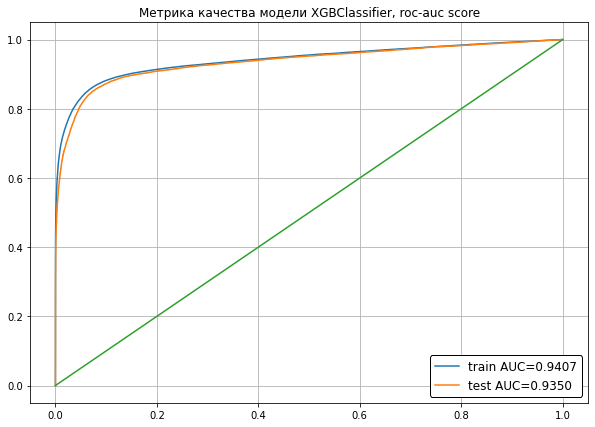

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели XGBClassifier, roc-auc score')
plt.show()

In [35]:
print('ROC-AUC score: ',round(roc_auc_score(y_test, y_test_predicted),4))
print('Accuracy score: ',round(accuracy_score(y_test, y_test_predicted_class),4))
print('Precision score: ',round(precision_score(y_test, y_test_predicted_class),4))
print('Recall score: ',round(recall_score(y_test, y_test_predicted_class),4))

ROC-AUC score:  0.935
Accuracy score:  0.9025
Precision score:  0.8913
Recall score:  0.8136


### Обучаем модель XGBoost с кастомными параметрами


In [36]:
%%time
boosting_model = xgboost.XGBClassifier(n_estimators=200,learning_rate = 0.1, max_depth = 5,subsample = 0.7)#,
#                                       reg_alpha=4,reg_lambda=10)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]
y_test_predicted_class = boosting_model.predict(X_test)

[16:25:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 8s, sys: 150 ms, total: 2min 9s
Wall time: 18.7 s


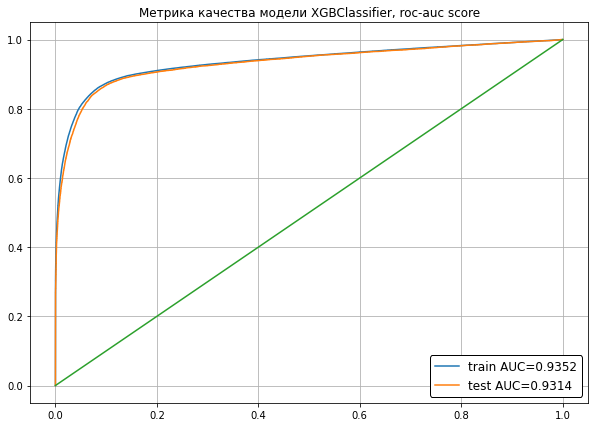

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.title('Метрика качества модели XGBClassifier, roc-auc score')
plt.show()

In [38]:
print('ROC-AUC score: ',round(roc_auc_score(y_test, y_test_predicted),4))
print('Accuracy score: ',round(accuracy_score(y_test, y_test_predicted_class),4))
print('Precision score: ',round(precision_score(y_test, y_test_predicted_class),4))
print('Recall score: ',round(recall_score(y_test, y_test_predicted_class),4))

ROC-AUC score:  0.9314
Accuracy score:  0.8972
Precision score:  0.8782
Recall score:  0.8112


### Проверяем модель на тестовых данных

Пусть следующие файлы будут тестовыми

In [14]:
test_files = [
    '2016-12-21 13:30:13.6800.csv',  #'2016-12-21 13_30_13.6800.csv',
    '2016-12-20 08:00:27.1000.csv' #'2016-12-20 08_00_27.1000.csv'
]

In [15]:
save_columns = [
    'time','620.E', '621.E', '622.E','623.E', 
    '624.E','625.E','626.E','627.E','628.E', 
    '629.E','630.E','631.E','632.E'
]

In [16]:
path = "/home/kl/Рабочий стол/Diploma_master/data/in_csv/"
file = test_files[0]

test_origin = pd.read_csv(path + file)
test = test_origin[save_columns]

In [17]:
test.head()

,time,620.E,621.E,622.E,623.E,624.E,625.E,626.E,627.E,628.E,629.E,630.E,631.E,632.E
0,2016-12-21 13:30:13.690000+00:00,7,-10,-9,-14,-4,3,-5,2,-6,5,-2,-12,6
1,2016-12-21 13:30:13.700000+00:00,8,5,-6,18,-6,-4,-7,9,-16,-3,2,0,3
2,2016-12-21 13:30:13.710000+00:00,6,2,-13,2,7,-1,-5,10,-8,-1,-6,13,-1
3,2016-12-21 13:30:13.720000+00:00,0,-13,-22,6,-3,6,5,10,-7,2,-5,-3,3
4,2016-12-21 13:30:13.730000+00:00,-5,-5,-4,7,-6,5,-1,8,-9,-9,0,4,3


In [18]:
X_test = test.drop(['time'],axis = 1)

#### Используем ранее обученную модель

In [19]:
%%time
best_model = clf

predict_proba = best_model.predict_proba(X_test.values)
predict_class = best_model.predict(X_test.values)

CPU times: user 1.65 s, sys: 21.1 ms, total: 1.67 s
Wall time: 417 ms


In [20]:
test_origin['predict_proba'] = test['620.E']
test_origin['predict_class'] = test['620.E']

test_origin['predict_proba'] = predict_proba
test_origin['predict_class'] = predict_class

In [21]:
# test_origin.to_csv('predict_{}'.format(file),index = False)

In [22]:
test_origin.head()

,time,620.E,620.N,620.Z,621.E,621.N,621.Z,622.E,622.N,622.Z,...,630.N,630.Z,631.E,631.N,631.Z,632.E,632.N,632.Z,predict_proba,predict_class
0,2016-12-21 13:30:13.690000+00:00,7,2,0,-10,-3,3,-9,-6,-3,...,2,2,-12,-5,-7,6,3,1,0.943517,0.0
1,2016-12-21 13:30:13.700000+00:00,8,-2,-2,5,-1,4,-6,-4,0,...,-2,-5,0,-4,-7,3,1,-3,0.897805,0.0
2,2016-12-21 13:30:13.710000+00:00,6,6,-12,2,-1,11,-13,0,11,...,-3,0,13,-7,-1,-1,3,6,0.941975,0.0
3,2016-12-21 13:30:13.720000+00:00,0,4,-4,-13,-6,0,-22,-1,11,...,-5,1,-3,-5,-1,3,0,5,0.854780,0.0
4,2016-12-21 13:30:13.730000+00:00,-5,-1,-4,-5,1,3,-4,7,11,...,-8,4,4,4,-1,3,5,-5,0.945372,0.0


Выделяем землетрясение и строим график

In [23]:
k = 0
count = 0
last_element = 0
index_sta,index_end = 0,0

porog_start = 5 # порог начала землетрясения
porog_end = 500 # порог конца

print('Файл {}'.format(file))
for ind, i in enumerate(test_origin['predict_class']):
    if (i==1)and(k==0):
        count+=1
    elif (i==0)and(k==1):
        count+=1
    else:
        count=0
        
    if (count==porog_start)and(k==0):
        print('Время начала землетрясения: ',test_origin['time'][ind-porog_start])
        k = 1 # землетрясение началось
        index_sta = ind-porog_start
        count = 0
        continue
    if (count==porog_end)and(k==1):
        print('Время окончания землетрясения: ', test_origin['time'][ind-porog_end])
        index_end = ind-porog_end
        break
#     if (i==1):
#         last_element = index
        
# print('Время окончания землетрясения: ', test_origin['time'][last_element])

# count = 0
# for index, i in enumerate(reversed(test_origin['predict_class'])):
#     if (i==1):
#         count+=1
#     if(count==150):
#         print('Время окончания землетрясения: ', test_origin['time'][len(test_origin)-150])
#         break

Файл 2016-12-21 13:30:13.6800.csv
Время начала землетрясения:  2016-12-21 13:31:24.760000+00:00
Время окончания землетрясения:  2016-12-21 13:32:52.340000+00:00


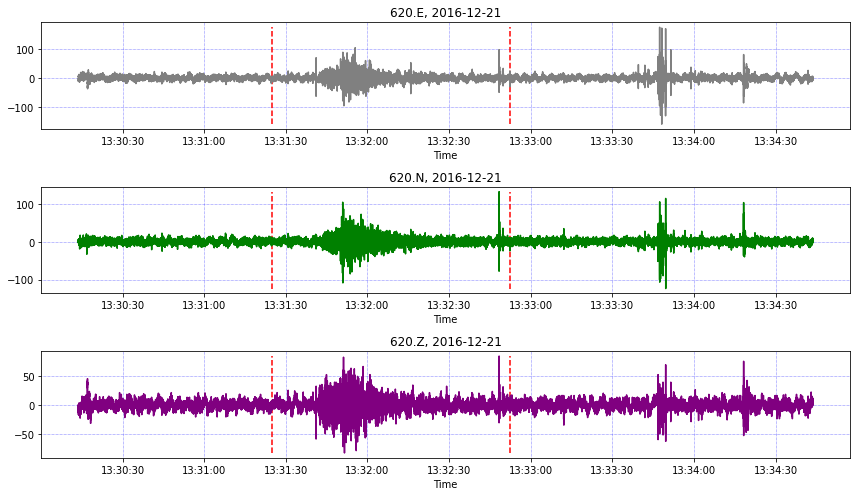

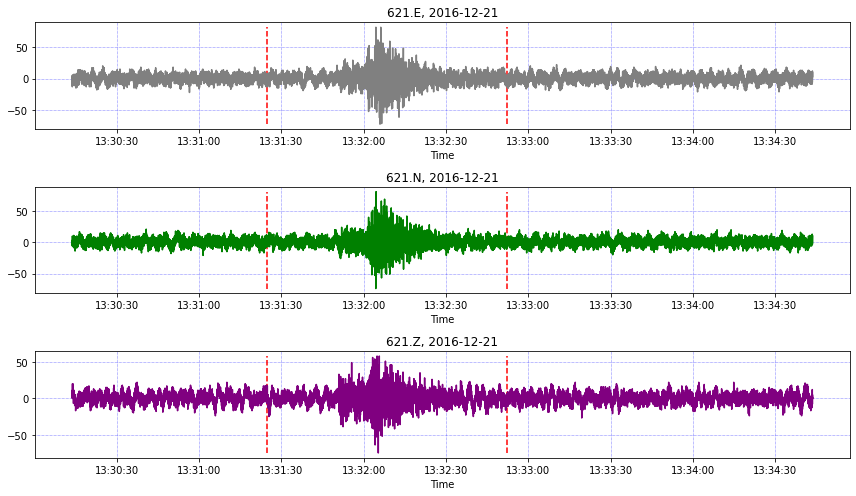

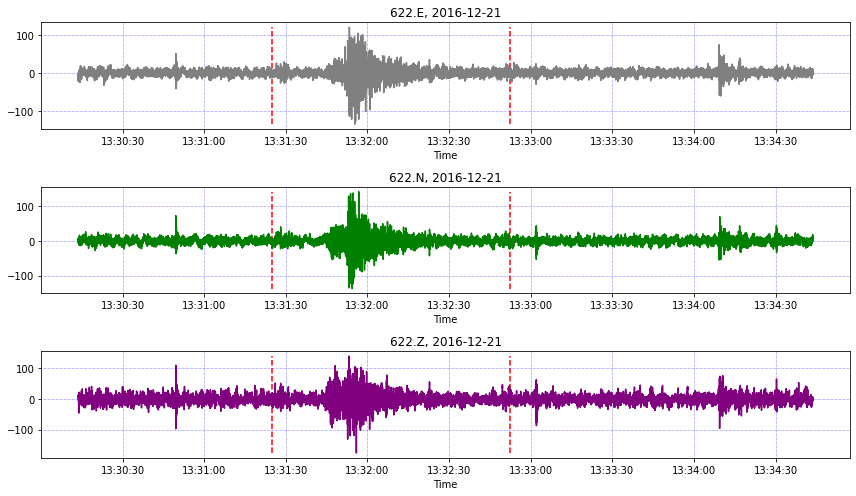

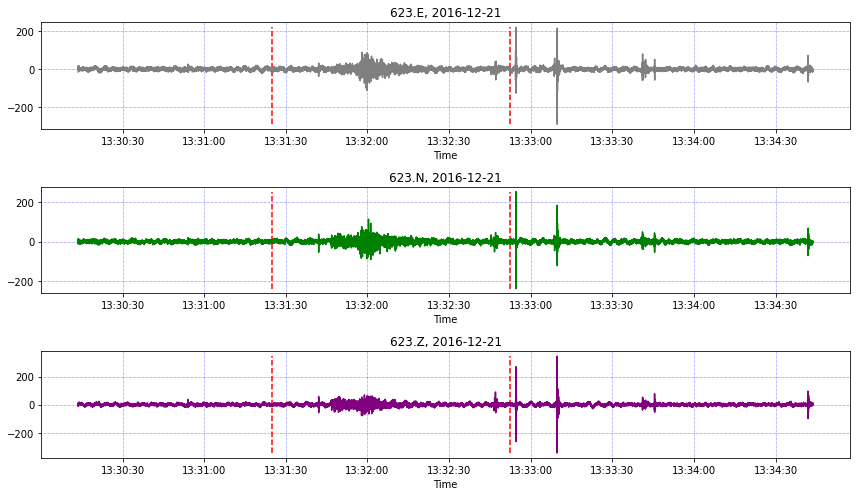

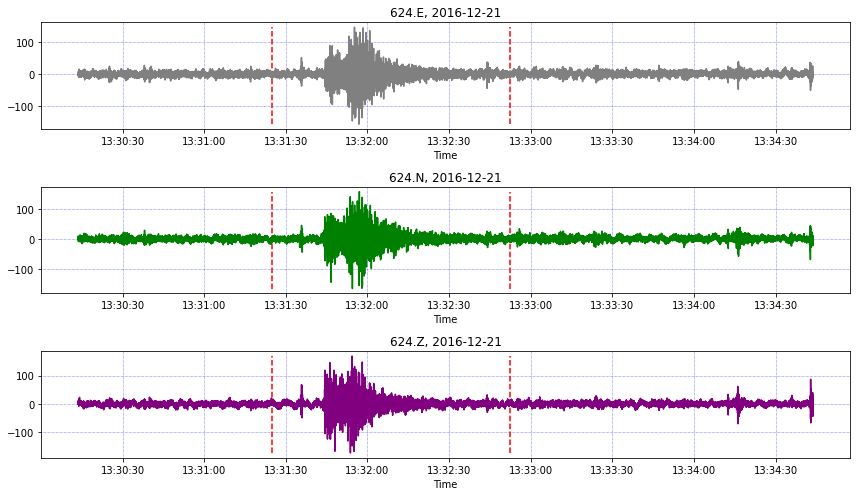

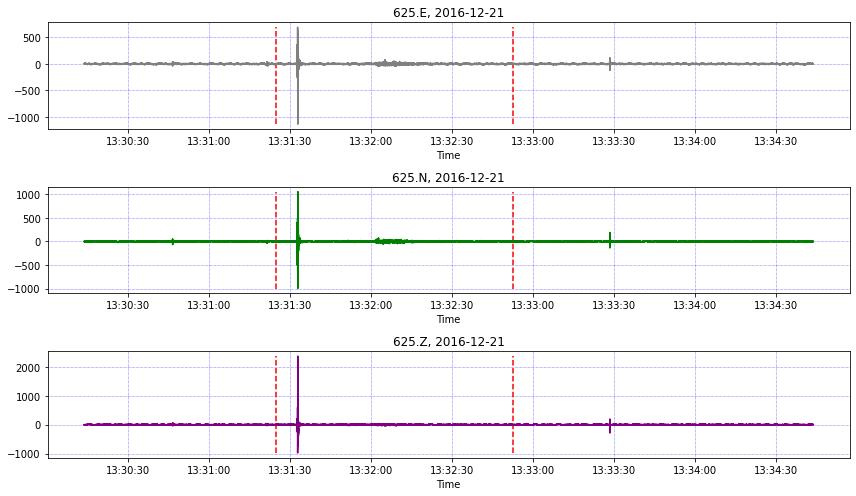

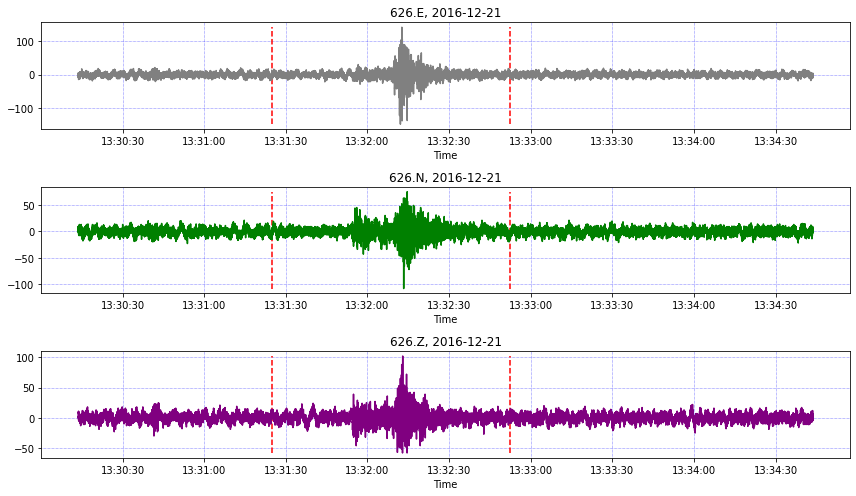

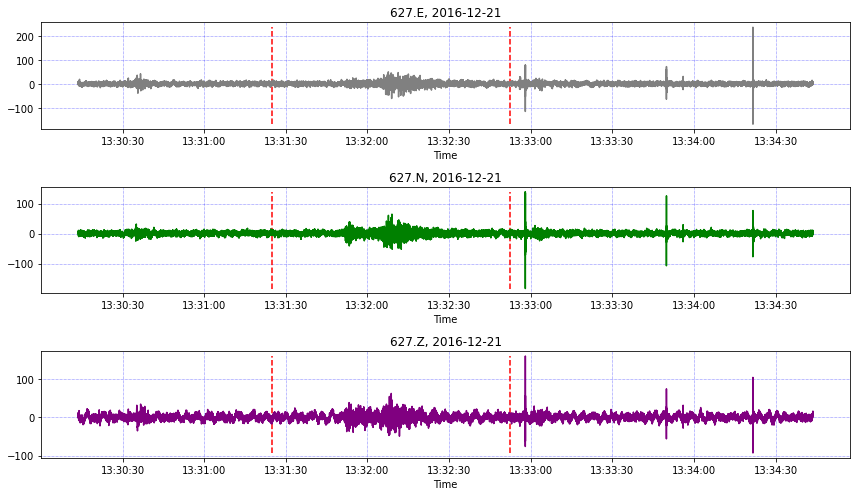

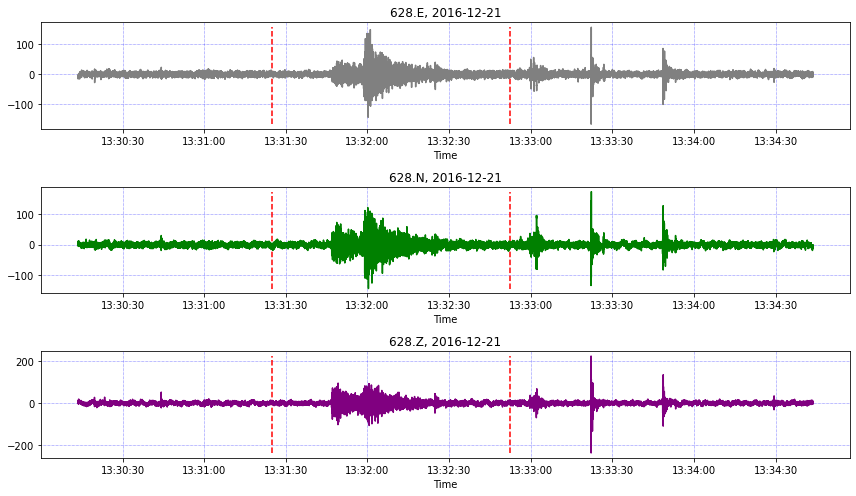

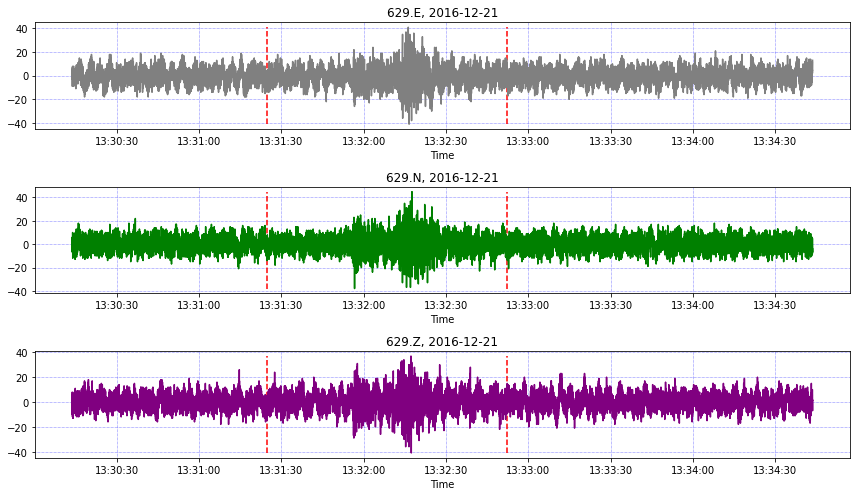

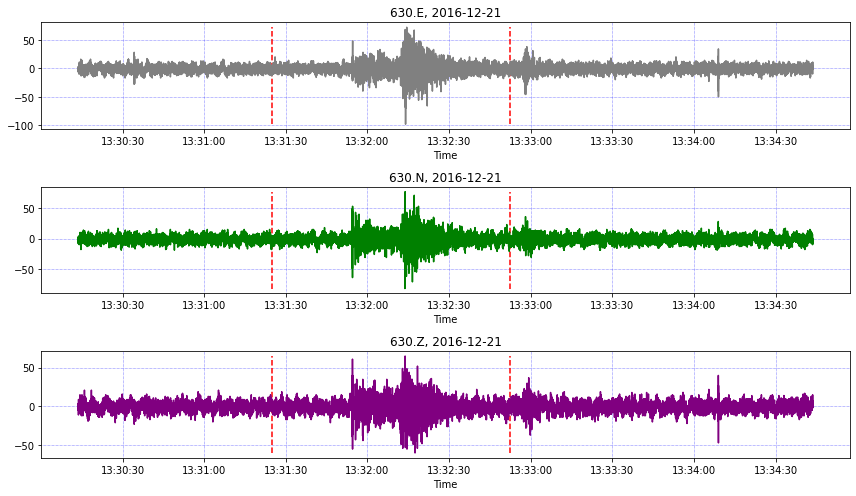

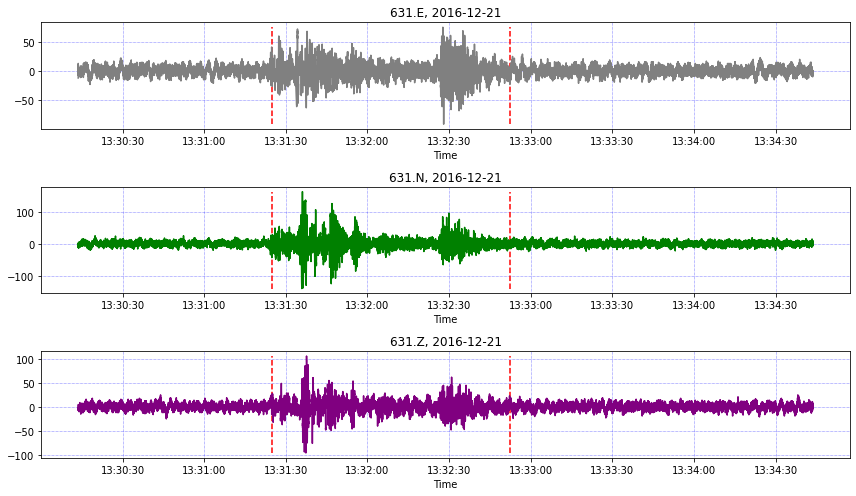

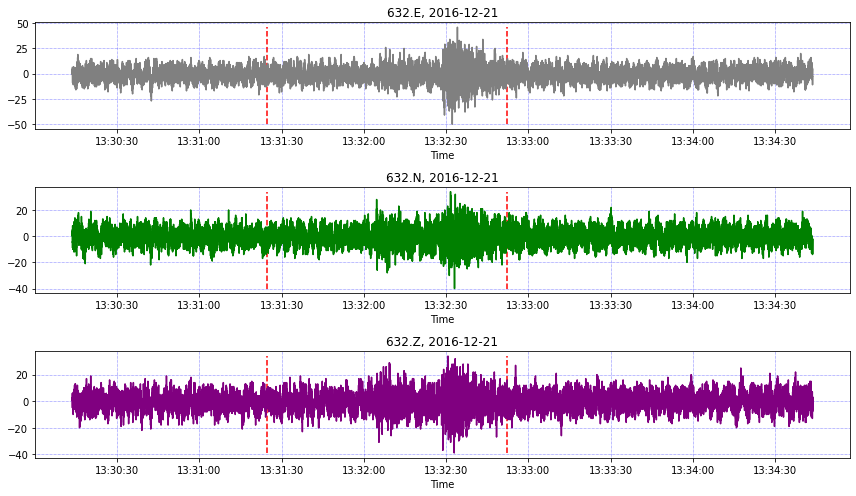

In [27]:
df5 = test_origin
df5['time'] = df5['time'].apply(lambda x: pd.Timestamp(x))
columns = list(df5.columns)[1:-2]
date = str(df5['time'][0].date())
    
    
for three_cols in range(0,len(columns),3):

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7))

    column = columns[three_cols]
    axs[0].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
    axs[0].plot(df5['time'], np.array(df5[column]), '-',color = 'grey')
    axs[0].vlines(df5['time'][index_sta], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
    axs[0].vlines(df5['time'][index_end], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
    axs[0].set_xlabel('Time')
    axs[0].set_title(column + ', ' + date)


    column = columns[three_cols+1]
    axs[1].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
    axs[1].plot(df5['time'], np.array(df5[column]), '-',color = 'green')
    axs[1].vlines(df5['time'][index_sta], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
    axs[1].vlines(df5['time'][index_end], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
    axs[1].set_xlabel('Time')
    axs[1].set_title(column + ', ' + date)


    column = columns[three_cols+2]
    axs[2].grid(color="blue", which="both", linestyle=':', linewidth=0.5)
    axs[2].plot(df5['time'], np.array(df5[column]), '-',color = 'purple')
    axs[2].vlines(df5['time'][index_sta], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
    axs[2].vlines(df5['time'][index_end], np.array(df5[column]).min(), np.array(df5[column]).max(), color = 'r',linestyle='dashed')
    axs[2].set_xlabel('Time')
    axs[2].set_title(column + ', ' + date)


    plt.tight_layout()
    plt.show()

    plt.cla()
    plt.clf()
    plt.close('all')

In [ ]:
### Сделать вывод графика и рисовать на нем вертикальные красные линии -- выделение землетрясения на графике
#python вертикальная линия на графике